In [1]:
!pip install statsforecast

import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd
import matplotlib.pyplot as plt
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import OneHotEncoder
from pylab import rcParams
import os
  
# Ignore harmless warnings 
import warnings 
warnings.filterwarnings("ignore") 


StatementMeta(, c38bfc22-6d73-4fb4-a9c3-cbc2132cc9d6, 3, Finished, Available, Finished)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.6/134.6 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.7/196.7 kB 43.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 62.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 48.5 MB/s eta 0:00:00


In [2]:
# Load dataset
konya = pd.read_parquet("abfss://Projeto_ii_ML_models@onelake.dfs.fabric.microsoft.com/Konya_sales.Lakehouse/Files/konya_features.parquet")

StatementMeta(, c38bfc22-6d73-4fb4-a9c3-cbc2132cc9d6, 4, Finished, Available, Finished)

In [3]:
# vizualize dataset
konya.head()
konya.tail()

# print info
print(konya.info())

StatementMeta(, c38bfc22-6d73-4fb4-a9c3-cbc2132cc9d6, 5, Finished, Available, Finished)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 532614 entries, 0 to 532613
Data columns (total 32 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   store_id               532614 non-null  object        
 1   product_id             532614 non-null  object        
 2   date                   532614 non-null  datetime64[ns]
 3   sales                  532614 non-null  float64       
 4   revenue                532614 non-null  float64       
 5   stock                  532614 non-null  float64       
 6   price                  531602 non-null  float64       
 7   promo_type_1           532614 non-null  category      
 8   promo_bin_1            75780 non-null   category      
 9   promo_type_2           532614 non-null  category      
 10  promo_bin_2            479 non-null     category      
 11  promo_discount_2       479 non-null     float64       
 12  promo_discount_type_2  479 non-null     cate

In [4]:
# change dtypes 

cat_col = ['store_id', 'product_id', 'season', 'week']
konya[cat_col] = konya[cat_col].astype('category')

# Drop columns not necessary
df = konya.copy()
# List of columns to drop
columns_to_drop = [
    'promo_bin_1', 
    'promo_bin_2',
    'revenue', 
    'promo_discount_2', 
    'promo_discount_type_2', 
    'hierarchy2_id', 
    'hierarchy3_id', 
    'hierarchy4_id', 
    'hierarchy5_id', 
    'city_id_old', 
    'country_id', 
    'city_code',
    'product_length', 
    'product_depth',
    'product_width',
    'weekday'
]

# Drop the specified columns
df = df.drop(columns=columns_to_drop, errors='ignore')

#confirm drop
df.info()

StatementMeta(, c38bfc22-6d73-4fb4-a9c3-cbc2132cc9d6, 6, Finished, Available, Finished)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 532614 entries, 0 to 532613
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   store_id       532614 non-null  category      
 1   product_id     532614 non-null  category      
 2   date           532614 non-null  datetime64[ns]
 3   sales          532614 non-null  float64       
 4   stock          532614 non-null  float64       
 5   price          531602 non-null  float64       
 6   promo_type_1   532614 non-null  category      
 7   promo_type_2   532614 non-null  category      
 8   cluster_id     532614 non-null  category      
 9   hierarchy1_id  532614 non-null  category      
 10  storetype_id   532614 non-null  category      
 11  store_size     532614 non-null  int64         
 12  season         532614 non-null  category      
 13  week           532614 non-null  category      
 14  holiday        532614 non-null  category      
 15  

In [5]:
# Filter products that are present in 2019
products_in_2019 = df[df['date'].dt.year == 2019]['product_id'].unique()

# Filter the original DataFrame to include only products sold in 2019
df_filtered = df[df['product_id'].isin(products_in_2019)]

# Display the last few rows of the filtered DataFrame
df_filtered.tail()

StatementMeta(, c38bfc22-6d73-4fb4-a9c3-cbc2132cc9d6, 7, Finished, Available, Finished)

,store_id,product_id,date,sales,stock,price,promo_type_1,promo_type_2,cluster_id,hierarchy1_id,storetype_id,store_size,season,week,holiday,month_name
532609,S0142,P0733,2019-09-30,0.0,12.0,0.75,PR14,PR03,cluster_7,H00,ST04,31,3,40,N,Sep
532610,S0142,P0741,2019-09-30,0.0,3.0,32.90,PR10,PR03,cluster_0,H01,ST04,31,3,40,N,Sep
532611,S0142,P0742,2019-09-30,0.0,5.0,69.90,PR07,PR03,cluster_0,H01,ST04,31,3,40,N,Sep
532612,S0142,P0747,2019-09-30,0.0,16.0,21.90,PR14,PR03,cluster_0,H01,ST04,31,3,40,N,Sep
532613,S0142,P0748,2019-09-30,0.0,18.0,18.90,PR14,PR03,cluster_0,H01,ST04,31,3,40,N,Sep


In [6]:
# Filter rows where 'unique_id' is 'P0035' that only appears in 2018 to confirm filtering
filtered_df = df_filtered[df_filtered['product_id'] == 'P0531']

print(filtered_df.tail())

StatementMeta(, c38bfc22-6d73-4fb4-a9c3-cbc2132cc9d6, 8, Finished, Available, Finished)

       store_id product_id       date  sales  stock  price promo_type_1  \
452911    S0142      P0531 2018-09-20    0.0   14.0   1.15         PR14   
453135    S0142      P0531 2018-09-21    8.0    6.0   1.15         PR14   
453359    S0142      P0531 2018-09-22    0.0    6.0   1.15         PR14   
453583    S0142      P0531 2018-09-23    1.0    5.0   1.15         PR14   
453807    S0142      P0531 2018-09-24    6.0    0.0   1.15         PR14   

       promo_type_2 cluster_id hierarchy1_id storetype_id  store_size season  \
452911         PR03  cluster_9           H00         ST04          31      3   
453135         PR03  cluster_9           H00         ST04          31      3   
453359         PR03  cluster_9           H00         ST04          31      3   
453583         PR03  cluster_9           H00         ST04          31      3   
453807         PR03  cluster_9           H00         ST04          31      3   

       week holiday month_name  
452911   38       N        Sep  
45

In [7]:
# Get unique store_ids
unique_store_ids = df_filtered['store_id'].unique()

# Create a dictionary of DataFrames, each keyed by store_id
store_datasets = {}
for store_id in unique_store_ids:
    store_datasets[store_id] = df_filtered[df_filtered['store_id'] == store_id].copy()

# dataset for store_id 'S0142'
store_S0142	 = store_datasets['S0142']
print("Store S0142 dataset:")
print(store_S0142.head())

# dataset for store_id S0094
store_S0094	 = store_datasets['S0094']
print("Store S0094 dataset:")
print(store_S0094.head())

# dataset for store_id S0030
store_S0030	 = store_datasets['S0030']
print("Store S0030 dataset:")
print(store_S0030.head())


StatementMeta(, c38bfc22-6d73-4fb4-a9c3-cbc2132cc9d6, 9, Finished, Available, Finished)

Store S0142 dataset:
       store_id product_id       date  sales  stock  price promo_type_1  \
329162    S0142      P0005 2017-01-02    0.0    2.0  33.90         PR14   
329163    S0142      P0015 2017-01-02    0.0   12.0   2.60         PR14   
329164    S0142      P0017 2017-01-02    0.0   17.0   1.49         PR14   
329165    S0142      P0018 2017-01-02    0.0    2.0   1.95         PR14   
329168    S0142      P0051 2017-01-02    0.0   15.0   0.70         PR14   

       promo_type_2 cluster_id hierarchy1_id storetype_id  store_size season  \
329162         PR03  cluster_9           H03         ST04          31      1   
329163         PR03  cluster_1           H00         ST04          31      1   
329164         PR03  cluster_6           H00         ST04          31      1   
329165         PR03  cluster_4           H00         ST04          31      1   
329168         PR03  cluster_7           H00         ST04          31      1   

       week holiday month_name  
329162    1   

In [8]:
# select store as df
df = store_S0094.copy() # replace according to store


StatementMeta(, c38bfc22-6d73-4fb4-a9c3-cbc2132cc9d6, 10, Finished, Available, Finished)

In [9]:
# get number of product_ids from store

store_S0094['product_id'].nunique()

StatementMeta(, c38bfc22-6d73-4fb4-a9c3-cbc2132cc9d6, 11, Finished, Available, Finished)

421

## S0094

In [10]:
# Change the granularity of time series data from daily to weekly

# Set 'ds' column as the index
df.set_index('date', inplace=True)
# Sort the DataFrame by the index (dates)
df.sort_index(inplace=True)

# Group by 'product_id' and resample to weekly frequency
df_weekly = df.groupby(['product_id']).resample('W-MON').agg({
    'sales': 'sum',  # Aggregate sales data
    'stock': 'last',  # Take the last stock value of the week
    'price': 'last',  # Last price for the week
    'promo_type_1': lambda x: x.mode().iloc[0] if not x.mode().empty else None,  # Mode of categorical variable
    'promo_type_2': lambda x: x.mode().iloc[0] if not x.mode().empty else None,  # Mode of categorical variable
    'cluster_id': lambda x: x.mode().iloc[0] if not x.mode().empty else None,  # Mode of categorical variable
    'hierarchy1_id': lambda x: x.mode().iloc[0] if not x.mode().empty else None,  # Mode of categorical variable
    'storetype_id': lambda x: x.mode().iloc[0] if not x.mode().empty else None,  # Mode of categorical variable
    'store_size': lambda x: x.mode().iloc[0] if not x.mode().empty else None,  # Mode of categorical variable
    'season': lambda x: x.mode().iloc[0] if not x.mode().empty else None,  # Mode of categorical variable
    'holiday': lambda x: x.mode().iloc[0] if not x.mode().empty else None, 
    'week': lambda x: x.mode().iloc[0] if not x.mode().empty else None,  # Mode of categorical variable
    'month_name': lambda x: x.mode().iloc[0] if not x.mode().empty else None,  # Mode of categorical variable
}).reset_index()

# Display the weekly aggregated DataFrame
print(df_weekly.head())

StatementMeta(, c38bfc22-6d73-4fb4-a9c3-cbc2132cc9d6, 12, Finished, Available, Finished)

  product_id       date  sales  stock  price promo_type_1 promo_type_2  \
0      P0005 2018-01-15    0.0    6.0   39.9         PR14         PR03   
1      P0005 2018-01-22    0.0    6.0   39.9         PR14         PR03   
2      P0005 2018-01-29    0.0    6.0   39.9         PR14         PR03   
3      P0005 2018-02-05    0.0    6.0   39.9         PR14         PR03   
4      P0005 2018-02-12    0.0    6.0   39.9         PR14         PR03   

  cluster_id hierarchy1_id storetype_id  store_size  season holiday  week  \
0  cluster_9           H03         ST04        45.0     1.0       N   2.0   
1  cluster_9           H03         ST04        45.0     1.0       N   3.0   
2  cluster_9           H03         ST04        45.0     1.0       N   4.0   
3  cluster_9           H03         ST04        45.0     1.0       N   5.0   
4  cluster_9           H03         ST04        45.0     1.0       N   6.0   

  month_name  
0        Jan  
1        Jan  
2        Jan  
3        Feb  
4        Feb  


In [11]:
df_weekly.info()
#df.info()

StatementMeta(, c38bfc22-6d73-4fb4-a9c3-cbc2132cc9d6, 13, Finished, Available, Finished)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39553 entries, 0 to 39552
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   product_id     39553 non-null  category      
 1   date           39553 non-null  datetime64[ns]
 2   sales          39553 non-null  float64       
 3   stock          36676 non-null  float64       
 4   price          36593 non-null  float64       
 5   promo_type_1   36676 non-null  object        
 6   promo_type_2   36676 non-null  object        
 7   cluster_id     36676 non-null  object        
 8   hierarchy1_id  36676 non-null  object        
 9   storetype_id   36676 non-null  object        
 10  store_size     36676 non-null  float64       
 11  season         36676 non-null  float64       
 12  holiday        36676 non-null  object        
 13  week           36676 non-null  float64       
 14  month_name     36676 non-null  object        
dtypes: category(1), dat

In [12]:
# Sort DataFrame by 'date'
df_weekly = df_weekly.sort_values(by='date')
#df = df.sort_values(by='date')

# Reset index after sorting
df_weekly.reset_index(drop=True, inplace=True)
#df.reset_index(drop=True, inplace=True)

StatementMeta(, c38bfc22-6d73-4fb4-a9c3-cbc2132cc9d6, 14, Finished, Available, Finished)

In [13]:
df_weekly.tail()
#df.tail()

StatementMeta(, c38bfc22-6d73-4fb4-a9c3-cbc2132cc9d6, 15, Finished, Available, Finished)

,product_id,date,sales,stock,price,promo_type_1,promo_type_2,cluster_id,hierarchy1_id,storetype_id,store_size,season,holiday,week,month_name
39548,P0504,2019-09-30,0.0,5.0,22.9,PR14,PR03,cluster_0,H01,ST04,45.0,3.0,N,39.0,Sep
39549,P0506,2019-09-30,1.0,7.0,11.9,PR14,PR03,cluster_0,H01,ST04,45.0,3.0,N,39.0,Sep
39550,P0509,2019-09-30,0.0,15.0,14.9,PR14,PR03,cluster_0,H01,ST04,45.0,3.0,N,39.0,Sep
39551,P0497,2019-09-30,2.0,0.0,3.0,PR14,PR03,cluster_4,H01,ST04,45.0,3.0,N,39.0,Sep
39552,P0748,2019-09-30,0.0,16.0,18.9,PR14,PR03,cluster_0,H01,ST04,45.0,3.0,N,39.0,Sep


# **ARIMA**

### All time range included

In [14]:
from statsforecast.arima import arima_string, auto_arima_f

# Adjust column names if needed
df_weekly = df_weekly.rename(columns={
    'product_id': 'unique_id',
    'date': 'ds',
    'sales': 'y'
})

#funcao do arima
def wmape(y_true, y_pred):
    return np.abs(y_true - y_pred).sum() / np.abs(y_true).sum()


# Rename variable
data = df_weekly.copy()

df_product = data.copy()

# Ensure 'unique_id' and 'ds' are properly formatted
df_product['unique_id'] = df_product['unique_id'].astype(str)
df_product['ds'] = pd.to_datetime(df_product['ds'])

# Separate sales and date from exogenous variables
data2 = df_product[['ds', 'unique_id', 'y']]

# Split data in train in different time-range
train = data2.loc[data2['ds'] < '2019-10-01']
# Count the occurrences of each product
product_counts = train['unique_id'].value_counts()
# Filter products that appear at least 5 times (to not arise error in crossvalidation)
products_to_keep = product_counts[product_counts >= 7].index
train = train[train['unique_id'].isin(products_to_keep)]


# Define AutoArima model
model = [AutoARIMA(season_length=52)]
#Forecast
sf = StatsForecast(models=model, freq='W-MON', n_jobs=-1)

# Get AutoARIMA parameters:
sf.fit(train)
sf.fitted_ # access an array of fitted models.
sf.fitted_[0][0].model_['arma']# access dictionary of all model's parameters
print('parameters (p, q, P, Q, period, d, D):')
print(sf.fitted_[0][0].model_['arma'])

print('model coeffitients for ar1, ar2, ar3, ma1, ma2:')
print(sf.fitted_[0][0].model_['coef'])

#Cross-validation
crossvalidation_df = sf.cross_validation(
    df = train,
    h = 2,
    step_size = 2,
    n_windows = 3, 
    level = [90], 
    fitted = True
  )

insample_sf_pred = sf.cross_validation_fitted_values()
print("insample_sf_pred:")
print(insample_sf_pred.tail(4))


print("crossvalidation_df:")
print(crossvalidation_df.head())
p = crossvalidation_df 
p = p.reset_index()
p.rename(columns={'index': 'unique_id'}, inplace=True)


print (p.head())

StatementMeta(, c38bfc22-6d73-4fb4-a9c3-cbc2132cc9d6, 16, Finished, Available, Finished)

parameters (p, q, P, Q, period, d, D):
(3, 2, 0, 0, 1, 0, 0)
model coeffitients for ar1, ar2, ar3, ma1, ma2:
{'ar1': -0.046338345938895215, 'ar2': 0.7080585121278967, 'ar3': 0.28414741558751067, 'ma1': -0.010333216933936773, 'ma2': -0.7866740164146069}
insample_sf_pred:
                  ds     cutoff    y  AutoARIMA
unique_id                                      
P0748     2019-08-26 2019-09-16  0.0        0.0
P0748     2019-09-02 2019-09-16  0.0        0.0
P0748     2019-09-09 2019-09-16  0.0        0.0
P0748     2019-09-16 2019-09-16  0.0        0.0
crossvalidation_df:
                  ds     cutoff    y  AutoARIMA  AutoARIMA-lo-90  \
unique_id                                                          
P0005     2019-08-26 2019-08-19  0.0   0.220323        -0.331663   
P0005     2019-09-02 2019-08-19  0.0   0.089859        -0.463215   
P0005     2019-09-09 2019-09-02  0.0   0.160502        -0.386404   
P0005     2019-09-16 2019-09-02  0.0   0.069956        -0.477953   
P0005     201

In [15]:
# return predictions 
p.head()

StatementMeta(, c38bfc22-6d73-4fb4-a9c3-cbc2132cc9d6, 17, Finished, Available, Finished)

,unique_id,ds,cutoff,y,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-hi-90
0,P0005,2019-08-26,2019-08-19,0.0,0.220323,-0.331663,0.772310
1,P0005,2019-09-02,2019-08-19,0.0,0.089859,-0.463215,0.642933
2,P0005,2019-09-09,2019-09-02,0.0,0.160502,-0.386404,0.707408
3,P0005,2019-09-16,2019-09-02,0.0,0.069956,-0.477953,0.617866
4,P0005,2019-09-23,2019-09-16,0.0,0.124376,-0.416930,0.665683


StatementMeta(, c38bfc22-6d73-4fb4-a9c3-cbc2132cc9d6, 18, Finished, Available, Finished)

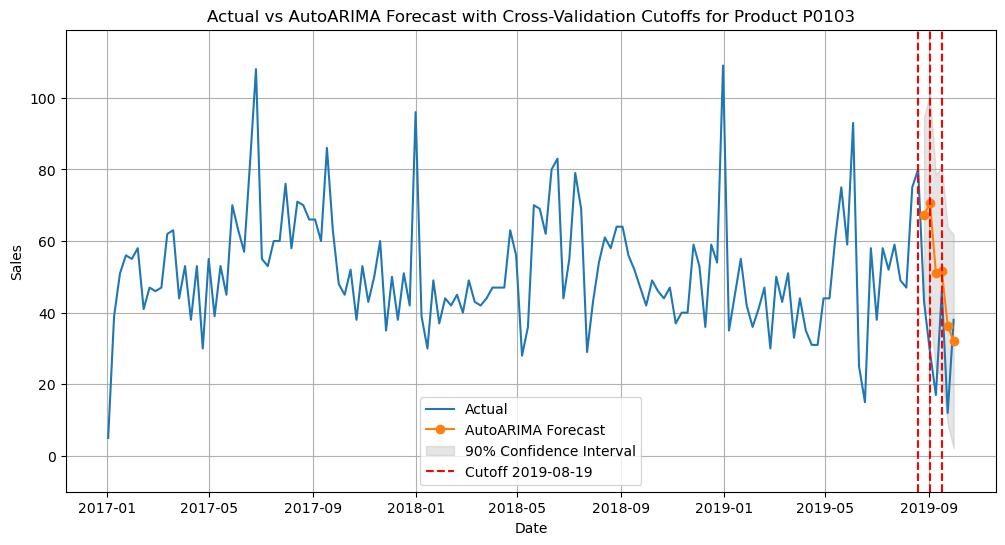

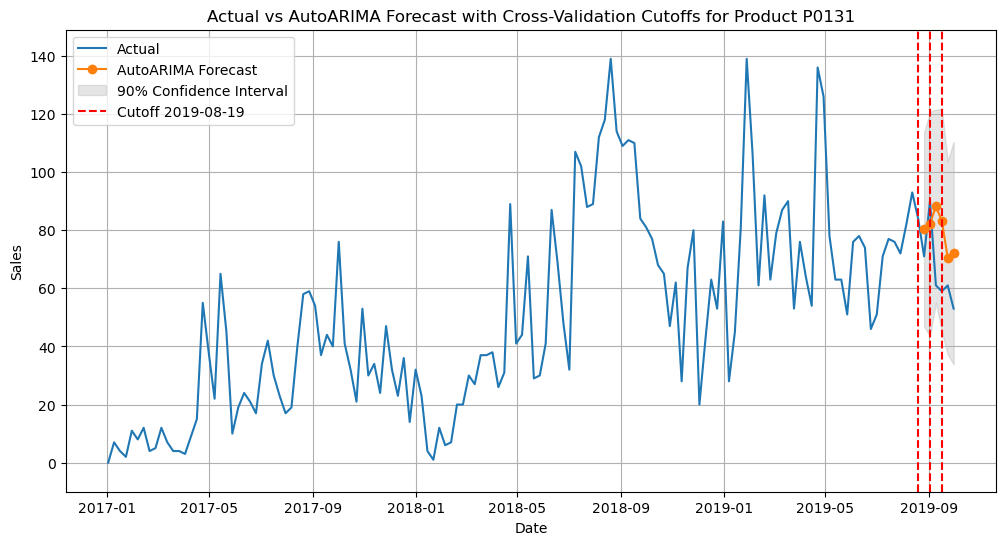

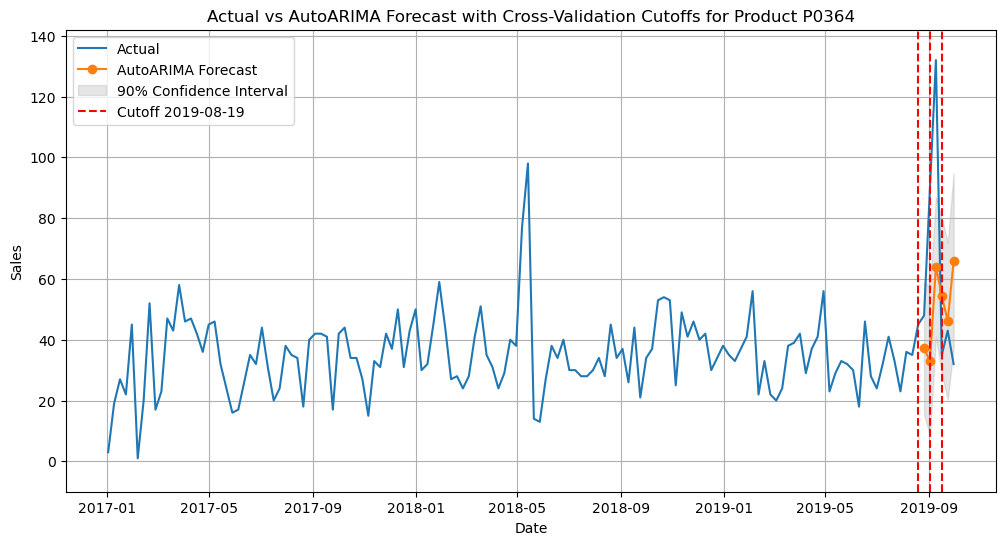

In [16]:
# List of unique IDs to filter
unique_ids = ['P0103', 'P0364', 'P0131']

# Filter the DataFrame based on the list of unique IDs
p_graph = p[p['unique_id'].isin(unique_ids)]
train_graph = train[train['unique_id'].isin(unique_ids)]

# Unique product IDs
product_ids = p_graph['unique_id'].unique()

# Plotting
for product_id in product_ids:
    product_df = p_graph[p_graph['unique_id'] == product_id]
    train_df = train_graph[train_graph['unique_id'] == product_id]
    
    plt.figure(figsize=(12, 6))
    
    # Plot actual values
    plt.plot(train_df['ds'], train_df['y'], label='Actual')
    
    # Plot forecasts
    plt.plot(product_df['ds'], product_df['AutoARIMA'], label='AutoARIMA Forecast', marker='o')
    
    # Plot confidence intervals
    plt.fill_between(product_df['ds'], product_df['AutoARIMA-lo-90'], product_df['AutoARIMA-hi-90'], color='gray', alpha=0.2, label='90% Confidence Interval')
    
    # Plot cutoff points for cross-validation
    for cutoff in product_df['cutoff'].unique():
        plt.axvline(x=cutoff, color='red', linestyle='--', label=f'Cutoff {cutoff.date()}' if cutoff == product_df['cutoff'].unique()[0] else "")
    
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.title(f'Actual vs AutoARIMA Forecast with Cross-Validation Cutoffs for Product {product_id}')
    plt.legend()
    plt.grid(True)
    
    # Define y-scale limits
    plt.ylim(-10, max(train_df['y'].max(), product_df['AutoARIMA-hi-90'].max()) + 10)
    
    plt.show()

In [16]:
# Add the store_id column
p['store_id'] = 'S0094'

# Reorder columns to place store_id at the beginning
p_filtered = p[['store_id'] + [col for col in p.columns if col != 'store_id']]

# Sort values by store_id and unique_id
p_filtered = p_filtered.sort_values(['store_id', 'unique_id'], ascending=True)


# Calculate evaluation metrics
p_filtered['error'] = p_filtered['y'] - p_filtered['AutoARIMA']
p_filtered['squared_error'] = (p_filtered['error']) ** 2
p_filtered['absolute_error'] = np.abs(p_filtered['error'])
p_filtered['absolute_percentage_error'] = p_filtered['absolute_error'] / p_filtered['y']

# Calculate MAE, MSE, and WMAPE at the group level
metrics_summary = p_filtered.groupby('unique_id').agg({
    'absolute_error': 'mean',  # MAE
    'squared_error': 'mean',   # MSE for RMSE calculation
    'y': 'sum',  # Sum of actual values for WMAPE
    'error': 'sum'  # Sum of absolute errors for WMAPE
}).rename(columns={
    'absolute_error': 'MAE',
    'squared_error': 'MSE',
    'y': 'sum_y',
    'error': 'sum_error'
})

# Calculate RMSE from MSE
metrics_summary['RMSE'] = np.sqrt(metrics_summary['MSE'])

# Calculate WMAPE
metrics_summary['WMAPE'] = (metrics_summary['sum_error'].abs() / metrics_summary['sum_y']) * 100

# Drop intermediate columns used for WMAPE calculation
metrics_summary = metrics_summary.drop(columns=['sum_y', 'sum_error'])

# Reset index to make unique_id a column
metrics_summary = metrics_summary.reset_index()

StatementMeta(, 3625d8e1-017f-4beb-b1d6-3f7e3ba14be7, 18, Finished, Available, Finished)

**TOP 3 PRODUCTS**

In [17]:
# List of unique IDs to filter
unique_ids = ['P0103', 'P0364', 'P0131']

# Filter the DataFrame based on the list of unique IDs
metrics_top = metrics_summary[metrics_summary['unique_id'].isin(unique_ids)]

metrics_top

StatementMeta(, 3625d8e1-017f-4beb-b1d6-3f7e3ba14be7, 19, Finished, Available, Finished)

,unique_id,MAE,MSE,RMSE,WMAPE
52,P0103,22.667185,691.618652,26.298643,66.983147
67,P0131,16.226892,323.058319,17.973824,20.682272
197,P0364,32.072086,1589.841309,39.872814,20.893215


**SAVE TOP 3**

In [ ]:
# Salvando o DataFrame de métricas como CSV no Fabric Lakehouse
metrics_path = 'abfss://Projeto_ii_ML_models@onelake.dfs.fabric.microsoft.com/Konya_sales.Lakehouse/Files/W_exog vs Wout_exog/METRICS_noexogeneous_week_all_dates_products_CROSSVAL_S0094_TOP_3.csv'
metrics_top.to_csv(metrics_path, index=False)

StatementMeta(, , , Cancelled, , Cancelled)

**SAVE GENERAL METRICS**

In [ ]:
# save to csv
#p.to_csv('abfss://Projeto_ii_ML_models@onelake.dfs.fabric.microsoft.com/Konya_sales.Lakehouse/Files/predictions_noexogeneous_week_alldates_products_CROSSVAL_S0094.csv') 



# Salvando o DataFrame de métricas como CSV no Fabric Lakehouse
metrics_path = 'abfss://Projeto_ii_ML_models@onelake.dfs.fabric.microsoft.com/Konya_sales.Lakehouse/Files/METRICS_noexogeneous_week_all_dates_products_CROSSVAL_S0094_ALL.csv'
metrics_summary.to_csv(metrics_path, index=False)

StatementMeta(, , , Cancelled, , Cancelled)

### From 2018

2017-2018 regists not included --> choose best time intervals to evaluate metrics for ARIMA

In [18]:
# Adjust column names if needed
df_weekly = df_weekly.rename(columns={
    'product_id': 'unique_id',
    'date': 'ds',
    'sales': 'y'
})

#funcao do arima
def wmape(y_true, y_pred):
    return np.abs(y_true - y_pred).sum() / np.abs(y_true).sum()


# Rename variable
data = df_weekly.copy()

df_product = data.copy()

# Ensure 'unique_id' and 'ds' are properly formatted
df_product['unique_id'] = df_product['unique_id'].astype(str)
df_product['ds'] = pd.to_datetime(df_product['ds'])

# Separate sales and date from exogenous variables
data2 = df_product[['ds', 'unique_id', 'y']]

# Split data in train in different time-range
train = data2.loc[data2['ds'] >= '2018-01-01']
# Count the occurrences of each product
product_counts = train['unique_id'].value_counts()
# Filter products that appear at least 5 times (to not arise error in crossvalidation)
products_to_keep = product_counts[product_counts >= 7].index
train = train[train['unique_id'].isin(products_to_keep)]


# Define AutoArima model
model = [AutoARIMA(season_length=52)]
#Forecast
sf = StatsForecast(models=model, freq='W-MON', n_jobs=-1)

#Cross-validation
crossvalidation_df = sf.cross_validation(
    df = train,
    h = 2,
    step_size = 2,
    n_windows = 3, 
    level = [90]
  )

print("crossvalidation_df:")
print(crossvalidation_df.head())
p = crossvalidation_df 
p = p.reset_index()
p.rename(columns={'index': 'unique_id'}, inplace=True)


print (p.head())

StatementMeta(, 3625d8e1-017f-4beb-b1d6-3f7e3ba14be7, 20, Finished, Available, Finished)

crossvalidation_df:
                  ds     cutoff    y  AutoARIMA  AutoARIMA-lo-90  \
unique_id                                                          
P0005     2019-08-26 2019-08-19  0.0   0.220323        -0.331663   
P0005     2019-09-02 2019-08-19  0.0   0.089859        -0.463215   
P0005     2019-09-09 2019-09-02  0.0   0.160502        -0.386404   
P0005     2019-09-16 2019-09-02  0.0   0.069956        -0.477953   
P0005     2019-09-23 2019-09-16  0.0   0.124376        -0.416930   

           AutoARIMA-hi-90  
unique_id                   
P0005             0.772310  
P0005             0.642933  
P0005             0.707408  
P0005             0.617866  
P0005             0.665683  
  unique_id         ds     cutoff    y  AutoARIMA  AutoARIMA-lo-90  \
0     P0005 2019-08-26 2019-08-19  0.0   0.220323        -0.331663   
1     P0005 2019-09-02 2019-08-19  0.0   0.089859        -0.463215   
2     P0005 2019-09-09 2019-09-02  0.0   0.160502        -0.386404   
3     P0005 2019-09-

In [19]:
# return predictions 
p.head()

StatementMeta(, 3625d8e1-017f-4beb-b1d6-3f7e3ba14be7, 21, Finished, Available, Finished)

,unique_id,ds,cutoff,y,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-hi-90
0,P0005,2019-08-26,2019-08-19,0.0,0.220323,-0.331663,0.772310
1,P0005,2019-09-02,2019-08-19,0.0,0.089859,-0.463215,0.642933
2,P0005,2019-09-09,2019-09-02,0.0,0.160502,-0.386404,0.707408
3,P0005,2019-09-16,2019-09-02,0.0,0.069956,-0.477953,0.617866
4,P0005,2019-09-23,2019-09-16,0.0,0.124376,-0.416930,0.665683


In [20]:
# Add the store_id column
p['store_id'] = 'S0094'

# Reorder columns to place store_id at the beginning
p_filtered = p[['store_id'] + [col for col in p.columns if col != 'store_id']]

# Sort values by store_id and unique_id
p_filtered = p_filtered.sort_values(['store_id', 'unique_id'], ascending=True)


# Calculate evaluation metrics
p_filtered['error'] = p_filtered['y'] - p_filtered['AutoARIMA']
p_filtered['squared_error'] = (p_filtered['error']) ** 2
p_filtered['absolute_error'] = np.abs(p_filtered['error'])
p_filtered['absolute_percentage_error'] = p_filtered['absolute_error'] / p_filtered['y']

# Calculate MAE, MSE, and WMAPE at the group level
metrics_summary = p_filtered.groupby('unique_id').agg({
    'absolute_error': 'mean',  # MAE
    'squared_error': 'mean',   # MSE for RMSE calculation
    'y': 'sum',  # Sum of actual values for WMAPE
    'error': 'sum'  # Sum of absolute errors for WMAPE
}).rename(columns={
    'absolute_error': 'MAE',
    'squared_error': 'MSE',
    'y': 'sum_y',
    'error': 'sum_error'
})

# Calculate RMSE from MSE
metrics_summary['RMSE'] = np.sqrt(metrics_summary['MSE'])

# Calculate WMAPE
metrics_summary['WMAPE'] = (metrics_summary['sum_error'].abs() / metrics_summary['sum_y']) * 100

# Drop intermediate columns used for WMAPE calculation
metrics_summary = metrics_summary.drop(columns=['sum_y', 'sum_error'])

# Reset index to make unique_id a column
metrics_summary = metrics_summary.reset_index()

StatementMeta(, 3625d8e1-017f-4beb-b1d6-3f7e3ba14be7, 22, Finished, Available, Finished)

In [21]:
# List of unique IDs to filter
unique_ids = ['P0103', 'P0364', 'P0131']

# Filter the DataFrame based on the list of unique IDs
metrics_top = metrics_summary[metrics_summary['unique_id'].isin(unique_ids)]

metrics_top

StatementMeta(, 3625d8e1-017f-4beb-b1d6-3f7e3ba14be7, 23, Finished, Available, Finished)

,unique_id,MAE,MSE,RMSE,WMAPE
52,P0103,23.281294,706.318054,26.576645,67.871788
67,P0131,16.460819,332.980072,18.247742,21.027180
197,P0364,32.061558,1498.125366,38.705624,19.771641


In [41]:
# Salvando o DataFrame de métricas como CSV no Fabric Lakehouse
metrics_path = 'abfss://Projeto_ii_ML_models@onelake.dfs.fabric.microsoft.com/Konya_sales.Lakehouse/Files/W_exog vs Wout_exog/METRICS_noexogeneous_week_from2018_products_CROSSVAL_S0094_TOP_3.csv'
metrics_top.to_csv(metrics_path, index=False)

StatementMeta(, f6eb805f-c444-4dc5-bd59-69b33d6ea14c, 43, Finished, Available, Finished)

In [21]:
# save to csv
#p.to_csv('abfss://Projeto_ii_ML_models@onelake.dfs.fabric.microsoft.com/Konya_sales.Lakehouse/Files/predictions_noexogeneous_week_from2018_products_CROSSVAL_S0094.csv') 



# Salvando o DataFrame de métricas como CSV no Fabric Lakehouse
metrics_path = 'abfss://Projeto_ii_ML_models@onelake.dfs.fabric.microsoft.com/Konya_sales.Lakehouse/Files/METRICS_noexogeneous_week_all_from2018_products_CROSSVAL_S0094_ALL.csv'
metrics_summary.to_csv(metrics_path, index=False)

StatementMeta(, 89dd3246-c835-455c-a32c-134a44f2574f, 23, Finished, Available, Finished)